In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Импортируем библиотеки, необходимые для преобразования признаков
import category_encoders as ce
# import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.downloader.download('vader_lexicon')

from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopy

import time
from termcolor import colored

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# Обзор датасетов

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [75]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [76]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [9]:
# Объединение датасетов в один с признаком-маяком: 1 - трейн, 0 - тест
df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['reviewer_score'] = 0 # дополняем тест пизнаком reviewer_score с нулевыми значениеми
data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [9]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Отели

## Наименование отеля и его адрес

In [10]:
# Поиск отелей с одинаковыми названиями
uniq_name = data[['hotel_address', 'hotel_name']].groupby('hotel_name').nunique()
uniq_name[uniq_name.hotel_address > 1]

,hotel_address
hotel_name,
Hotel Regina,3


In [11]:
# Создаём новый признак - город - и добоваляем его в название отеля
data['city'] = data.hotel_address.apply(lambda x: ''.join(x.split()[-5]) if x.split()[-1] == 'Kingdom' else ''.join(x.split()[-2]))
data.hotel_name = data.hotel_name + ' ' + data.city

In [12]:
data.hotel_name.unique().shape

(1494,)

In [13]:
# Бинарное кодирование наименований отелей (больше 15 значений)
bin_encoder = ce.BinaryEncoder()
data_bin = bin_encoder.fit_transform(data.hotel_name)
data = pd.concat([data, data_bin], axis=1)

## Расстояние до центра города

In [14]:
# Cоздаём новый признак из кортежей координат

data['coordinates'] = data[['lat', 'lng']].apply(lambda x: np.nan if x.isnull().any() else tuple(x), axis=1)


In [17]:
# Словарь названий отелей, у которых не заполнены координаты, и их адресов
bd = pd.isnull(data.coordinates)
nam_coord_nul = data[bd].groupby('hotel_name')['hotel_address'].max().to_dict()
nam_coord_nul

{'Austria Trend Hotel Schloss Wilhelminenberg Wien Vienna': 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
 'City Hotel Deutschmeister Vienna': 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
 'Cordial Theaterhotel Wien Vienna': 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
 'Derag Livinghotel Kaiser Franz Joseph Vienna Vienna': 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
 'Fleming s Selection Hotel Wien City Vienna': 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
 'Holiday Inn Paris Montmartre Paris': '23 Rue Damr mont 18th arr 75018 Paris France',
 'Hotel Advance Barcelona': 'Sep lveda 180 Eixample 08011 Barcelona Spain',
 'Hotel Atlanta Vienna': 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
 'Hotel City Central Vienna': 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
 'Hotel Daniel Vienna Vienna': 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
 'Hotel Park Villa Vienna': 'Hasenauerstra e 12 19 D bli

In [18]:
def get_city_coord(arg):
    """
    Функция получение координат по топониму
    Args:
    arg (str): наименование или адрес отеля, астионим

    Returns:
    tuple: долгота и широта через запятую
    """
    geolocator = Nominatim(user_agent='Tester')
    location = geolocator.geocode(arg)
    return (location.latitude, location.longitude)

data['city_coord'] = data.city.apply(get_city_coord) 

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Milan&format=json&limit=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fd94402e810>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [19]:
# Замена адресов в словаре с помощью библиотеки geopy, но так как в kaggle выходит исключение,
# координаты получены в другой среде. 
hotel_dict = {'Austria Trend Hotel Schloss Wilhelminenberg Wien Vienna': (48.221415,
  16.2874559),
 'City Hotel Deutschmeister Vienna': (48.2211573, 16.3620293),
 'Cordial Theaterhotel Wien Vienna': (48.2098335, 16.3475615),
 'Derag Livinghotel Kaiser Franz Joseph Vienna Vienna': (48.2462468,
  16.3387236),
 'Flemings Selection Hotel Wien City Vienna': (48.2098335, 16.3475615),
 'Holiday Inn Paris Montmartre Paris': (48.8888806, 2.3331948),
 'Hotel Advance Barcelona': (41.3832344, 2.162940206993912),
 'Hotel Atlanta Vienna': (48.2203284, 16.3558289),
 'Hotel City Central Vienna': (48.2278937, 16.3882026),
 'Hotel Daniel Vienna Vienna': (48.1888627, 16.3838516356697),
 'Hotel Park Villa Vienna': (48.2331682, 16.3470804),
 'Hotel Pension Baron am Schottentor Vienna': (48.2212841, 16.3546402),
 'Maison Albar Hotel Paris Op ra Diamond Paris': (48.875248, 2.3233746),
 'Mercure Paris Gare Montparnasse Paris': (48.839701, 2.323519),
 'NH Collection Barcelona Podium Barcelona': (41.3929354, 2.1758883),
 'Renaissance Barcelona Hotel Barcelona': (41.3927154, 2.1674921),
 'Roomz Vienna Vienna': (48.18672145, 16.420653090404993)}

# Создание промежуточного датасета с недостающими координатами
coord_new = pd.DataFrame(hotel_dict.items(), columns=['hotel_name', 'coordinates'])

# Заполнение пропусков в координатах
data = data.merge(
    coord_new,
    on='hotel_name',
    how='left',
    suffixes=('','\x00')).sort_index(axis=1).fillna(method='bfill')[data.columns]

In [21]:
# Получение координат центров городов (в другой среде)
city_dict = {'Milan': (45.4641943, 9.1896346),
 'Amsterdam': (52.3730796, 4.8924534),
 'Barcelona': (41.3828939, 2.1774322),
 'London': (51.5073359, -0.12765),
 'Paris': (48.8588897, 2.3200410217200766),
 'Vienna': (48.2083537, 16.3725042)}

# Создание нового промежуточного призннака с координатами городов
city_coord = pd.DataFrame(city_dict.items(), columns=['city', 'city_coord'])

In [22]:
# Добавление промежуточного признака с координатами городов
data = data.merge(
    city_coord,
    on='city',
    how='left'
    )

# Создание нового признака с расстоянием до центра города в км
data['distance'] = data[['coordinates', 'city_coord']].apply(lambda x: str(geodesic(x[0], x[1])).split()[0], axis=1).astype(float).round(2)

# Постояльцы

Все люди разные, а значит будет разная и их реакция на одно и тоже явление, событие или предмет, поэтому необходимо разделить ревьюеров на основании имеющейся о них информации: будем пытаться использовать данные о национальности, характеристики их путешествия, их активности в оценках отелей

## Национальность

В данных есть сведения лишь о странах, по-видимому, гражданами которых являются постояльцы отелей, что, конечно, не предвносит какой-то национальный колорит в оценках, но может оказать на них влияние. Таких стран более 200, поэтому возьмём только 10 тех, чьи граждане оставили максимальное количество отзывов, остальные поместим в одну группу 

In [24]:
print('Количество стран, из которых приехали ревьюеры', colored(f'{data.reviewer_nationality.nunique()}', 'red'))

Количество стран, из которых приехали ревьюеры 227


In [26]:
# Проведём однокартное кодирование 10 национальностей постояльцев, оставивших наибольшее количество отзывов
top_nat = data['reviewer_nationality'].value_counts().nlargest(10).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_nat else 'other' )
data = pd.get_dummies(data, columns=['reviewer_nationality'])

KeyError: 'reviewer_nationality'

## Теги, указанные путешественниками

Ревьюерам, видимо, предлагалось указать сведения о своём посещении по шести критериям:
- путешествие с домашними животными
- состав путешествующих
- цель поездки
- характеристика размещения
- продолжительность поездки
- использование мобильного устройства для отправки отзыва

предположим, что на оценку может повлиять только состав путешественников, так как коллективный разум может существенно изменять оценку, а также цель поездки, так как в командировке менее тщательно выбираешь отель, а значит и менее предвзято к нему относишься

In [28]:
# Посчитаем количество уникальных тегов
tage_cnt = {}
for x in data.tags:
    for i in x[2:-2].strip().split(' \', \' '):
        if i in tage_cnt:
            tage_cnt[i] +=1
        else:
            tage_cnt[i] = 1

print('Первые по наибольшему количеству 10 тегов\n', colored(f'{sorted(dict(list(tage_cnt.items())[:10]), key=tage_cnt.get)}', 'red'))

Первые по наибольшему количеству 10 тегов
 ['Triple Room', 'Twin Room', 'Double Room', 'Group', 'Business trip', 'Solo traveler', 'Stayed 2 nights', 'Stayed 1 night', 'Couple', 'Leisure trip']


In [31]:
data.tags.head(10)

0    [Leisure_trip, Couple, Double_Room, Stayed_2_n...
1    [Leisure_trip, Group, Triple_Room, Stayed_1_ni...
2    [Business_trip, Solo_traveler, Twin_Room, Stay...
3    [Leisure_trip, Couple, Ambassador_Junior_Suite...
4    [Business_trip, Solo_traveler, Classic_Double_...
5    [Business_trip, Solo_traveler, Standard_Double...
6    [Leisure_trip, Couple, Queen_Room, Stayed_1_ni...
7    [Business_trip, Solo_traveler, Executive_Room,...
8         [Group, Double_or_Twin_Room, Stayed_1_night]
9    [Couple, Standard_Triple_Room, Stayed_2_nights...
Name: tags, dtype: object

In [ ]:
def get_tags(arg):
    """Функция очищает маcсив тегов от лишних символов
    Args:
        arg (str): строка тегов
        
    Returns:
        list: список тегов без лишних символов
    
    """
    tags = []
    for tag in list(arg[2:-2].strip().split(' \', \' ')):
        tag = tag.replace(' ', '_') # Заменяем нижним подчёркиванием пробелы между словами одного тега
        tags.append(tag)
        
    return tags


data.tags = data.tags.apply(get_tags)

In [32]:
# Проверяем наиболее полные облака тэгов
data.loc[data.tags.apply(lambda x: len(x)).sort_values(ascending=False)[:10].index].tags.values

array([list(['With_a_pet', 'Leisure_trip', 'Couple', 'Deluxe_Double_Room', 'Stayed_1_night', 'Submitted_from_a_mobile_device']),
       list(['With_a_pet', 'Leisure_trip', 'Couple', 'Junior_Suite', 'Stayed_3_nights', 'Submitted_from_a_mobile_device']),
       list(['With_a_pet', 'Leisure_trip', 'Family_with_young_children', 'Triple_Room', 'Stayed_4_nights', 'Submitted_from_a_mobile_device']),
       list(['With_a_pet', 'Leisure_trip', 'Family_with_older_children', '2_rooms', 'Stayed_3_nights', 'Submitted_from_a_mobile_device']),
       list(['With_a_pet', 'Leisure_trip', 'Family_with_young_children', 'Classic_Double_Room', 'Stayed_2_nights', 'Submitted_from_a_mobile_device']),
       list(['With_a_pet', 'Leisure_trip', 'Couple', 'Classic_Room', 'Stayed_1_night', 'Submitted_from_a_mobile_device']),
       list(['With_a_pet', 'Leisure_trip', 'Group', 'Superior_Twin_Room', 'Stayed_1_night', 'Submitted_from_a_mobile_device']),
       list(['With_a_pet', 'Leisure_trip', 'Couple', 'Superior_

In [33]:
# Наиболее интересным из тегов является состав путешественников, так как оценка одного человека и 
# формирование её на основе двух, а тем более нескольких мнений должны отличаться, поэтому создаём новый признак,
# в который заносим состав, разделённый на три группы - один,пара, несколко человек
data['composition'] = data.tags.apply(lambda x: 'one' if 'Solo_traveler'in x else (
        'two' if 'Couple' in x else (
        'more' if 'Group' in x or
        'Family_with_young_children' in x or 
        'Family_with_older_children' in x or
        'Travelers_with_friends' in x else 0)))

# Кодируем новый признак
data = pd.get_dummies(data, columns=['composition'])

In [34]:
# Создаём и кодируем признак, показывающий цель поездки - отдых или работа. При этом будем исходить,
# что если этот тег не указан, то коммандировочные просто предпочли скрыть назначение своего прибытия
data['purpose'] = data.tags.apply(lambda x: 1 if 'Leisure_trip'in x else 0)

## Количество отзывов путешественников

In [45]:
data.total_number_of_reviews_reviewer_has_given.mean()

7.166000953972754

# Отзывы

## Дата отзыва

In [35]:
# Изменение формата представления даты отзыва
data['review_date'] = pd.to_datetime(data['review_date'])

# Новый признак - год отзыва
data['review_year'] = data['review_date'].dt.year

# Новые признаки - сезон отзыва
def get_seasons(month):
    """Функция преобразует дату во времена года

    Args:
        month (int): номер месяца
        
    Returns:
        str: название времени года
    
    """
    if month in list(range(3,6)):
        return 'spring'
    elif month in list(range(6,9)):
        return 'summer'
    elif month in list(range(9,12)):
        return 'autumn'
    else:
        return 'winter'



data['review_seasons'] = data['review_date'].dt.month.apply(get_seasons)

In [36]:
data['review_seasons']

0         summer
1         winter
2         autumn
3         autumn
4         spring
           ...  
515733    spring
515734    winter
515735    winter
515736    spring
515737    summer
Name: review_seasons, Length: 515738, dtype: object

In [38]:
# Завсисимость средней оценки от сезона
pivot_seasons = data.groupby(['review_year', 'review_seasons'])['reviewer_score'].mean()
pivot_seasons

review_year  review_seasons
2015         autumn            6.212497
             summer            6.264161
             winter            6.342589
2016         autumn            6.242509
             spring            6.360973
             summer            6.309405
             winter            6.354133
2017         spring            6.277652
             summer            6.274948
             winter            6.353192
Name: reviewer_score, dtype: float64

In [39]:
# Однократное кодирование номинальный признаков
ohe_col = ['review_year', 'review_seasons']
data = pd.get_dummies(data, columns=ohe_col)


## Тональность отзыва

In [22]:
sent_analyzer = SentimentIntensityAnalyzer()
sent_analyzer.polarity_scores(data.negative_review[0])

{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'compound': -0.0554}

In [40]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,composition_one,composition_two,purpose,review_year_2015,review_year_2016,review_year_2017,review_seasons_autumn,review_seasons_spring,review_seasons_summer,review_seasons_winter
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci Milan,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,1,1,0,0,1,0,0,1,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel Amsterdam,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,1,0,1,0,0,0,0,1
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton Bar...,Pillows,3,351,Nice welcoming and service,5,...,1,0,0,1,0,0,1,0,0,0
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia Milan,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,0,1,1,1,0,0,1,0,0,0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,2016-05-16,9.1,Hotel Esther a Amsterdam,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,1,0,0,0,1,0,0,1,0,0


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 54 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   hotel_address                                    515738 non-null  object        
 1   additional_number_of_scoring                     515738 non-null  int64         
 2   review_date                                      515738 non-null  datetime64[ns]
 3   average_score                                    515738 non-null  float64       
 4   hotel_name                                       515738 non-null  object        
 5   negative_review                                  515738 non-null  object        
 6   review_total_negative_word_counts                515738 non-null  int64         
 7   total_number_of_reviews                          515738 non-null  int64         
 8   positive_review         

In [ ]:
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score']  

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [ ]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [ ]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [41]:
data.select_dtypes(include=['object']).columns

Index(['hotel_address', 'hotel_name', 'negative_review', 'positive_review',
       'tags', 'days_since_review', 'city', 'coordinates', 'city_coord'],
      dtype='object')

In [44]:
# убираем вспомогательные и лишние признаки
drop_list = ['days_since_review', 'review_date', 'lat', 'lng', 'purpose']
for i in data.select_dtypes(include=['object']).columns:
    if i not in drop_list:
        drop_list.append(i)
data.drop(drop_list, axis=1, inplace=True)


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 41 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   additional_number_of_scoring                     515738 non-null  int64  
 1   average_score                                    515738 non-null  float64
 2   review_total_negative_word_counts                515738 non-null  int64  
 3   total_number_of_reviews                          515738 non-null  int64  
 4   review_total_positive_word_counts                515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given       515738 non-null  int64  
 6   sample                                           515738 non-null  int64  
 7   reviewer_score                                   515738 non-null  float64
 8   hotel_name_0                                     515738 non-null  int64  
 9   hotel_name_1   

In [46]:
# Делим объединённый датасет на трнировочную тестовую часть, а тестовую на признаки и таргет
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'reviewer_score'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [47]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [48]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 39), (386803, 40), (386803, 39), (309442, 39), (77361, 39))

In [49]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [50]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [51]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


In [52]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9482610610814277


In [ ]:
df_train.head()

In [53]:

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X, y)[0])
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

ValueError: Unknown label type: (array([10. ,  6.3,  7.5, ...,  8.3,  9.2,  8.8]),)

<AxesSubplot:>

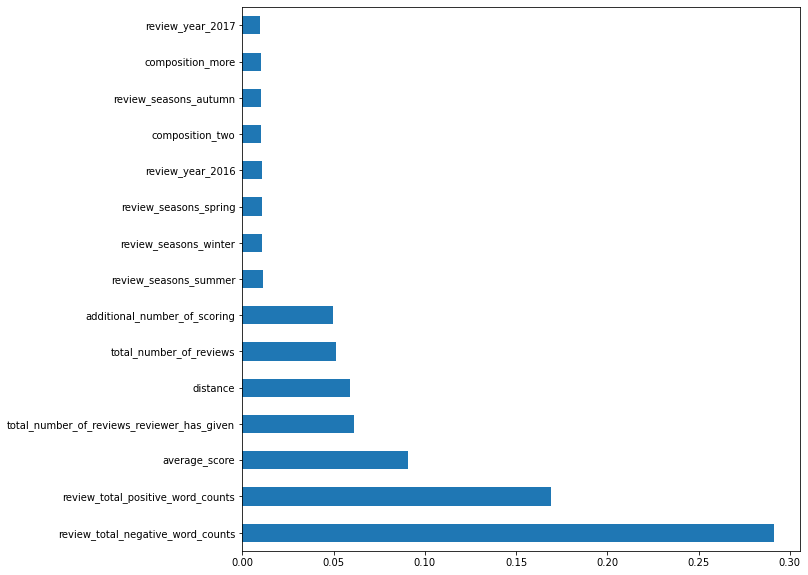

In [54]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [55]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [56]:
predict_submission

array([8.835, 7.388, 8.094, ..., 7.934, 9.317, 6.979])

In [66]:
list(sample_submission)

['reviewer_score', 'id']

In [57]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.835,488440
1,7.388,274649
2,8.094,374688
3,9.409,404352
4,9.359,451596
5,8.755,302161
6,7.038,317079
7,7.700,13963
8,8.658,159785
9,8.062,195089
